Component orientations (from dataless seed downloaded on June 29, 2019)
BHU: az 135.1 dip -29.4
BHV: az 15.0  dip -29.2
BHW: az 255.0 dip -29.7

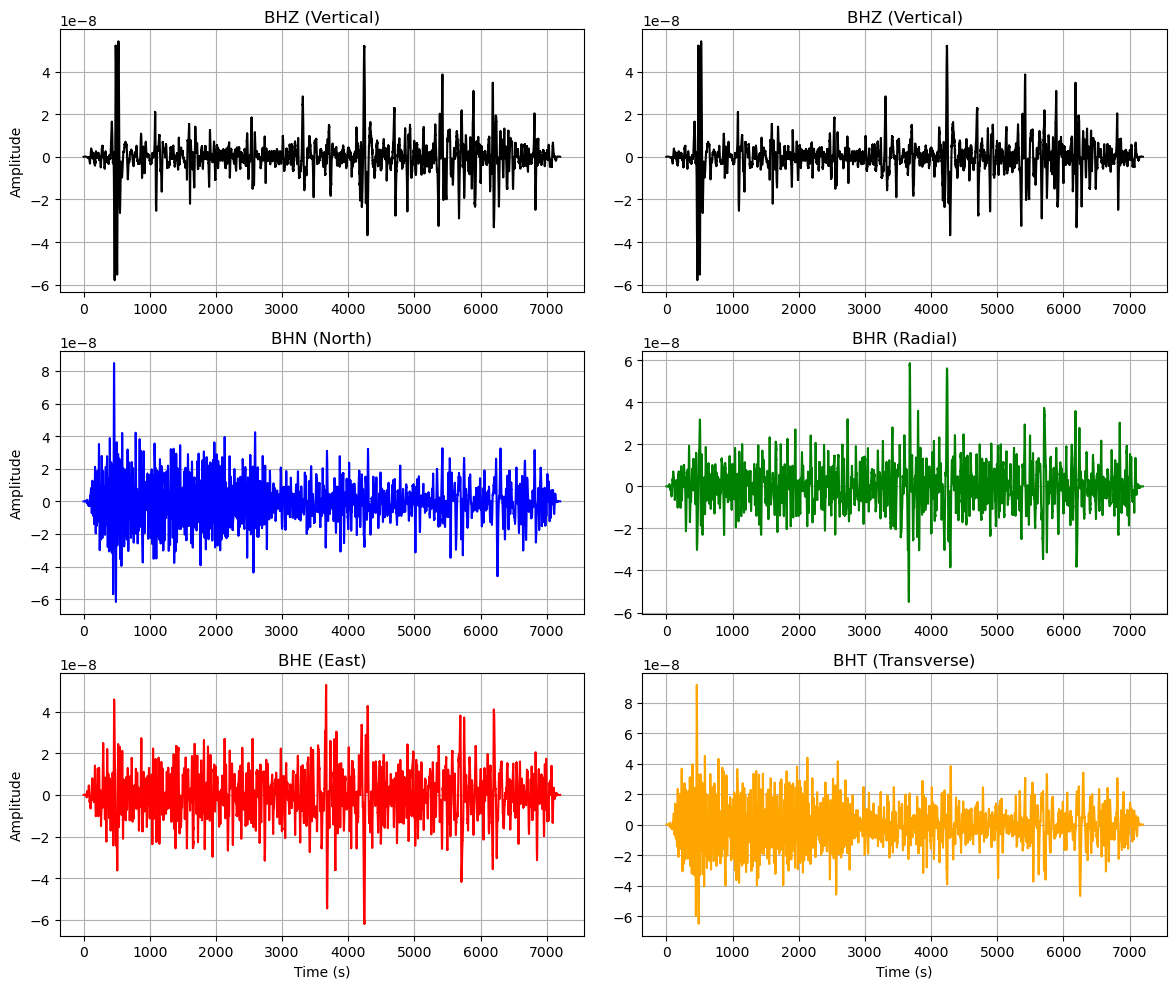

In [2]:
import os
from obspy import read
from obspy.signal.rotate import rotate_ne_rt
import matplotlib.pyplot as plt

# === Parameters ===
# filedir = "H:\My Drive\Research\SharpSSPy"
filedir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/SharpSSPy"

datadir = os.path.join(filedir, "misc/S0976a_Deglitched/")
dtype = "DISP"

# === Load the 3 components ===
st_z = read(os.path.join(datadir, f"S0976a_{dtype}_BHZ.SAC"))[0]
st_n = read(os.path.join(datadir, f"S0976a_{dtype}_BHN.SAC"))[0]
st_e = read(os.path.join(datadir, f"S0976a_{dtype}_BHE.SAC"))[0]

# === Extract back-azimuth from SAC header ===
baz = 101

# === Metadata checks ===
assert st_z.stats.delta == st_n.stats.delta == st_e.stats.delta, "Sampling rates differ"
assert len(st_z.data) == len(st_n.data) == len(st_e.data), "Trace lengths differ"

# === Rotate to RT ===
tr_r, tr_t = rotate_ne_rt(st_n.data, st_e.data, baz)

# === Create rotated traces ===
tr_r_obj = st_n.copy()
tr_t_obj = st_e.copy()
tr_r_obj.data = tr_r
tr_t_obj.data = tr_t
tr_r_obj.stats.channel = "BHR"
tr_t_obj.stats.channel = "BHT"

# === Save rotated components ===
output_dir = datadir  # Save in same directory
st_z.write(os.path.join(output_dir, f"S0976a_{dtype}_BHZ_rotated.SAC"), format="SAC")
tr_r_obj.write(os.path.join(output_dir, f"S0976a_{dtype}_BHR_rotated.SAC"), format="SAC")
tr_t_obj.write(os.path.join(output_dir, f"S0976a_{dtype}_BHT_rotated.SAC"), format="SAC")

# === Plotting ===
t = st_z.times()

plt.figure(figsize=(12, 10))

# --- Before Rotation: Z, N, E ---
plt.subplot(3, 2, 1)
plt.plot(t, st_z.data, color="black")
plt.title("BHZ (Vertical)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(3, 2, 3)
plt.plot(t, st_n.data, color="blue")
plt.title("BHN (North)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(3, 2, 5)
plt.plot(t, st_e.data, color="red")
plt.title("BHE (East)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()

# --- After Rotation: Z, R, T ---
plt.subplot(3, 2, 2)
plt.plot(t, st_z.data, color="black")
plt.title("BHZ (Vertical)")
plt.grid()

plt.subplot(3, 2, 4)
plt.plot(t, tr_r, color="green")
plt.title("BHR (Radial)")
plt.grid()

plt.subplot(3, 2, 6)
plt.plot(t, tr_t, color="orange")
plt.title("BHT (Transverse)")
plt.xlabel("Time (s)")
plt.grid()

plt.tight_layout()
plt.show()



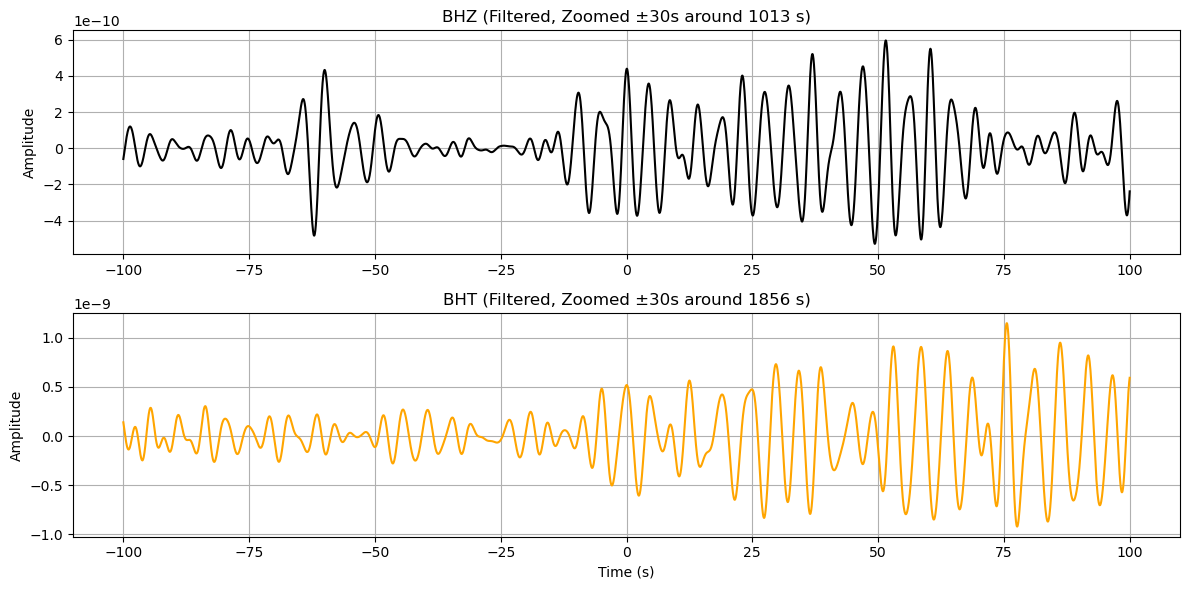

In [3]:
from obspy import read
import matplotlib.pyplot as plt

# Load rotated traces
st_z = read(os.path.join(datadir, "S0976a_DISP_BHZ_rotated.SAC"))[0]
st_t = read(os.path.join(datadir, "S0976a_DISP_BHT_rotated.SAC"))[0]

# Apply bandpass filter (e.g., 0.02–0.2 Hz)
st_z_filtered = st_z.copy().filter("bandpass", freqmin=1/6, freqmax=1/2.8, corners=2, zerophase=True)
st_t_filtered = st_t.copy().filter("bandpass", freqmin=1/6, freqmax=1/2.8, corners=2, zerophase=True)

# Zoom windows
z_time_center = 1013 + 30*60 - 8.4  # seconds
t_time_center = 1856 + 30*60 - 8.6  # seconds
winb = 100  # - seconds
wina = 100  # + seconds

# Time arrays
t_z = st_z_filtered.times()
t_t = st_t_filtered.times()

# Indices for zooming
idx_z = (t_z >= z_time_center - winb) & (t_z <= z_time_center + wina)
idx_t = (t_t >= t_time_center - winb) & (t_t <= t_time_center + wina)

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t_z[idx_z]-z_time_center, st_z_filtered.data[idx_z], color='black')
plt.title("BHZ (Filtered, Zoomed ±30s around 1013 s)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t_t[idx_t]-t_time_center, st_t_filtered.data[idx_t], color='orange')
plt.title("BHT (Filtered, Zoomed ±30s around 1856 s)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()


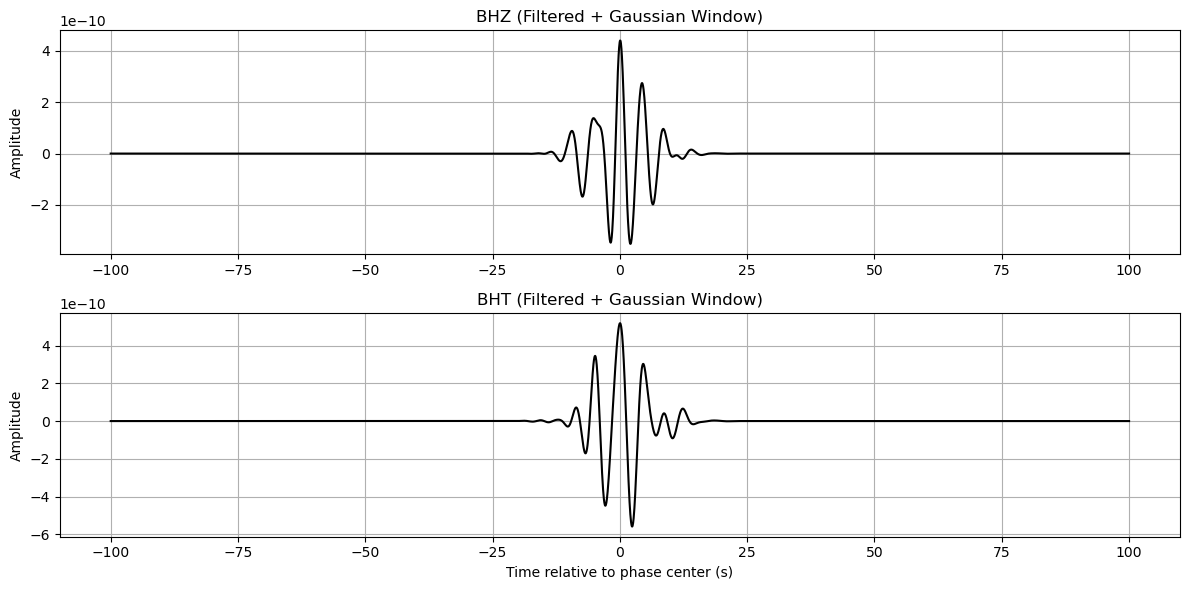

In [4]:
import numpy as np
# --- Apply Gaussian Window ---

# Zoomed times relative to center
t_zoom_z = t_z[idx_z] - z_time_center
t_zoom_t = t_t[idx_t] - t_time_center

# Gaussian window (sigma = 6 s)
sigma = 6.0
gaussian_window_z = np.exp(-0.5 * (t_zoom_z / sigma)**2)
gaussian_window_t = np.exp(-0.5 * (t_zoom_t / sigma)**2)

# Apply window to seismograms
z_filtered_windowed = st_z_filtered.data[idx_z] * gaussian_window_z
t_filtered_windowed = st_t_filtered.data[idx_t] * gaussian_window_t

# Plot windowed waveforms
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t_zoom_z, z_filtered_windowed, color='black')
plt.title("BHZ (Filtered + Gaussian Window)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t_zoom_t, t_filtered_windowed, color='black')
plt.title("BHT (Filtered + Gaussian Window)")
plt.xlabel("Time relative to phase center (s)")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()


In [7]:
import pickle
from sharp_ss.model import Prior
# --- Extract and Save Reference (P) and Data (D) with Time Vector ---

# Define cut window (in seconds)
cut_b, cut_a = -30, 30
cut_len = cut_a - cut_b

# Time vector centered at zero
time = np.arange(cut_b, cut_a, st_z_filtered.stats.delta)
npts_cut = len(time)

# Cut D: filtered data centered around phase arrival
idx_cut_z = (t_z >= z_time_center + cut_b) & (t_z < z_time_center + cut_a)
idx_cut_t = (t_t >= t_time_center + cut_b) & (t_t < t_time_center + cut_a)

D_z = st_z_filtered.data[idx_cut_z]
D_t = st_t_filtered.data[idx_cut_t]

# Ensure correct length for D
if len(D_z) != npts_cut:
    D_z = np.pad(D_z, (0, npts_cut - len(D_z)))
if len(D_t) != npts_cut:
    D_t = np.pad(D_t, (0, npts_cut - len(D_t)))

# Cut P
idx_cut_z = (t_zoom_z >= cut_b) & (t_zoom_z < cut_a)
idx_cut_t = (t_zoom_t >= cut_b) & (t_zoom_t < cut_a)
P_z = z_filtered_windowed[idx_cut_z]
P_t = t_filtered_windowed[idx_cut_t]

# # Pad P to match full cut length
# pad_left_z = np.sum(time < t_zoom_z[0])
# pad_right_z = npts_cut - len(z_filtered_windowed) - pad_left_z
# P_z = np.pad(z_filtered_windowed, (pad_left_z, pad_right_z))

# pad_left_t = np.sum(time < t_zoom_t[0])
# pad_right_t = npts_cut - len(t_filtered_windowed) - pad_left_t
# P_t = np.pad(t_filtered_windowed, (pad_left_t, pad_right_t))

# Normalize
norm_z = max(np.abs(P_z))
P_z = P_z / norm_z
D_z = D_z / norm_z
norm_t = max(np.abs(P_t))
P_t = P_t / norm_t
D_t = D_t / norm_t

# Save to .npz files
np.savez(filedir+"/data/S0976a_PP_src_6s/S0976a_PP.npz", P=P_z, D=D_z, time=time)
np.savez(filedir+"/data/S0976a_SS_src_6s/S0976a_SS.npz", P=P_t, D=D_t, time=time)

# dt = time[1] - time[0]
# prior = Prior(tlen=time[-1], stdP=0.1, dt=dt, widRange=(0.1, 2), ampRange=(-0.3, 0.), negOnly=True, align=3., maxN=2)
# # Save prior
# with open("./S0976a_PP/prior.pkl", "wb") as f:
#     pickle.dump(prior, f)
# with open("./S0976a_SS/prior.pkl", "wb") as f:
#     pickle.dump(prior, f)
# with open("./S0976a_PP_SS/prior.pkl", "wb") as f:
#     pickle.dump(prior, f)

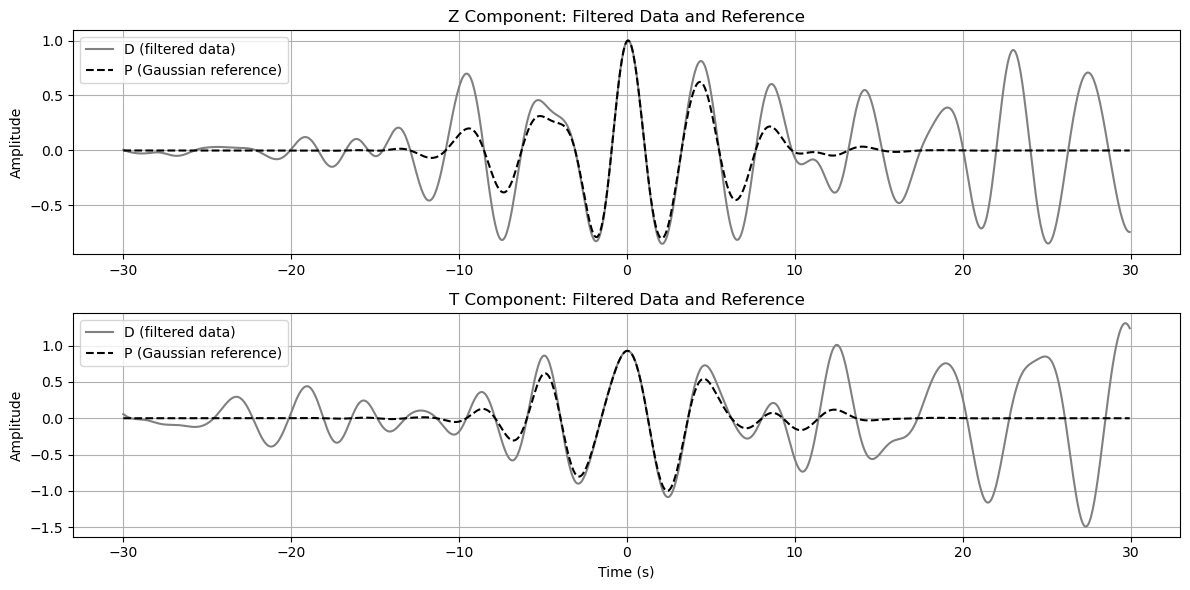

In [9]:
# --- Plot P and D to Confirm ---

data_Z = np.load(filedir+"/data/S0976a_PP_src_6s/S0976a_PP.npz")
data_T = np.load(filedir+"/data/S0976a_SS_src_6s/S0976a_SS.npz")

# Extract
time = data_Z["time"]
P_z, D_z = data_Z["P"], data_Z["D"]
P_t, D_t = data_T["P"], data_T["D"]

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, D_z, label="D (filtered data)", color='gray')
plt.plot(time, P_z, label="P (Gaussian reference)", color='black', linestyle='--')
plt.title("Z Component: Filtered Data and Reference")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(time, D_t, label="D (filtered data)", color='gray')
plt.plot(time, P_t, label="P (Gaussian reference)", color='black', linestyle='--')
plt.title("T Component: Filtered Data and Reference")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [7]:
from obspy import read

# Load any SAC file (Z component here)
tr = read("./Data/S0976a_Deglitched/S0976a_DISP_BHZ_rotated.SAC")[0]

# Start time in UTCDateTime
start_time = tr.stats.starttime

print(f"Start time of the SAC file: {start_time}")


Start time of the SAC file: 2021-08-25T03:02:28.356000Z


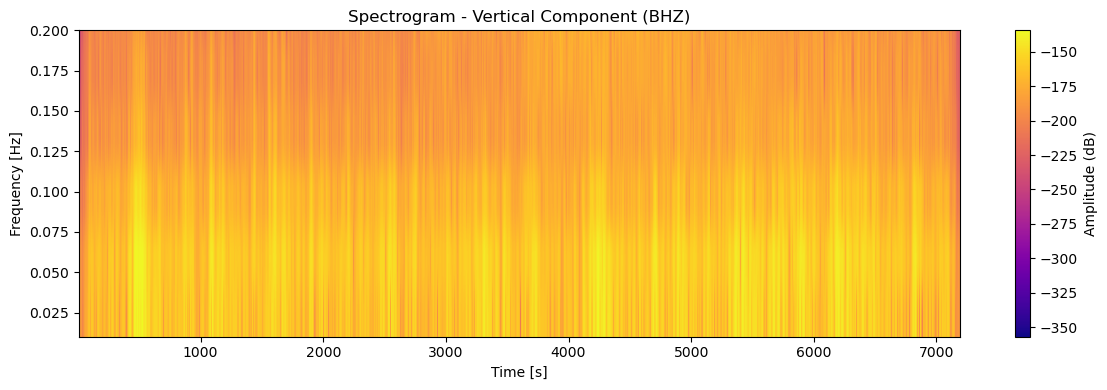

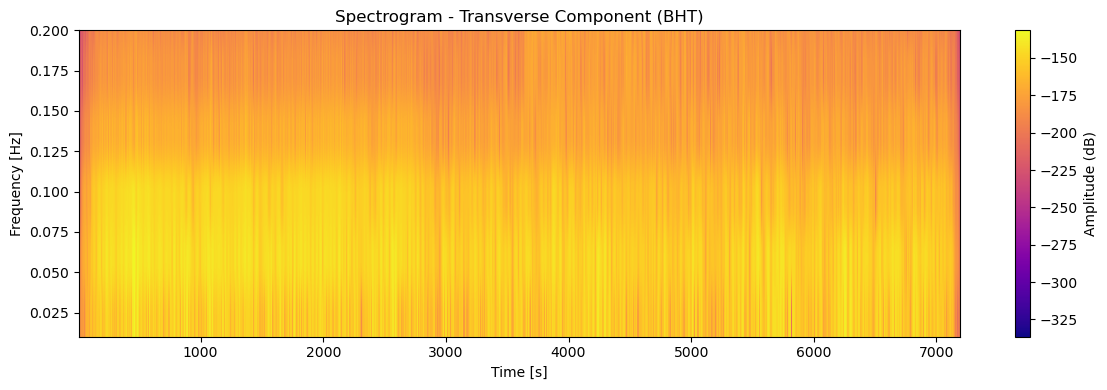

In [6]:
from obspy import read
import matplotlib.pyplot as plt

# Load rotated traces
st_z = read("./Data/S0976a_Deglitched/S0976a_DISP_BHZ_rotated.SAC")[0]
st_t = read("./Data/S0976a_Deglitched/S0976a_DISP_BHT_rotated.SAC")[0]

# Spectrogram for vertical component
plt.figure(figsize=(12, 4))
plt.specgram(st_z.data, Fs=st_z.stats.sampling_rate, NFFT=512, noverlap=384, cmap='plasma')
plt.title("Spectrogram - Vertical Component (BHZ)")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.ylim(0.01, 0.2)
plt.colorbar(label="Amplitude (dB)")
plt.tight_layout()
plt.show()

# Spectrogram for transverse component
plt.figure(figsize=(12, 4))
plt.specgram(st_t.data, Fs=st_t.stats.sampling_rate, NFFT=512, noverlap=384, cmap='plasma')
plt.title("Spectrogram - Transverse Component (BHT)")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.ylim(0.01, 0.2)
plt.colorbar(label="Amplitude (dB)")
plt.tight_layout()
plt.show()
